# Data Cleaning and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## What are all these columns?
Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - date house was sold
* **price** - price is prediction target
* **bedrooms** - number of Bedrooms/House
* **bathrooms** - number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** -  square footage of the lot
* **floors** - total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has a view
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip code
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.sqft_basement.value_counts(normalize= True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
2610.0    0.000046
207.0     0.000046
2810.0    0.000046
1008.0    0.000046
2390.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

0.2% of the data is marked as '?' while 59.3% is marked as '0.0'. 

In [7]:
# change ? in column to 0 - most commonly seen value
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

In [8]:
df.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
2610.0        1
207.0         1
2810.0        1
1008.0        1
2390.0        1
Name: sqft_basement, Length: 303, dtype: int64

In [9]:
# change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float64')

In [10]:
# see how many rows have a value for sqft_basement
len (df.loc[df['sqft_basement'] > 0])

8317

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

In [12]:
# look at null values in waterfront
df.waterfront.value_counts(normalize= True)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64

In [13]:
# look at null values in view
df.view.value_counts(normalize= True)

0.0    0.901923
2.0    0.044441
3.0    0.023591
1.0    0.015325
4.0    0.014721
Name: view, dtype: float64

In [14]:
# look at null values in yr_renovated column
df.yr_renovated.value_counts(normalize= True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1946.0    0.000056
1959.0    0.000056
1971.0    0.000056
1951.0    0.000056
1954.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

99.2% of homes are not considered waterfront properties.

90% of homes do not have a view. While there are more categories, and replacing the null values with 0 may still be iffy, there are not very many missing values.

95.8% of homes have never been renovated. 

We can feel secure in replacing those all the missing values with zeros.

In [15]:
df.fillna(0, inplace= True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  float64       
 9   view           21597 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  float64       
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   2159

Most columns will likely have duplicates - especially the categorical columns. But the 'id' should have only one id per entry. Let's check that out.

In [17]:
# check id column for duplicate entries
df.id.duplicated().sum()

177

In [18]:
df_id_dups = df[df.duplicated('id')]

In [19]:
df_id_dups.reset_index(drop= True, inplace= True)

In [20]:
df.loc[df['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500
94,6021501535,2014-12-23,700000.0,3,1.5,1580,5000,1.0,0.0,0.0,3,8,1290,290.0,1939,0.0,98117,47.687,-122.386,1570,4500


In [21]:
df.loc[df['id'] == 4139480200]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
313,4139480200,2014-06-18,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,2014-12-09,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,3,11,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244


In [22]:
df.loc[df['id'] == 3969300030]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,2014-07-23,165000.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138
346,3969300030,2014-12-29,239900.0,4,1.0,1000,7134,1.0,0.0,0.0,3,6,1000,0.0,1943,0.0,98178,47.4897,-122.24,1020,7138


It looks like the rows that have identical id numbers were sold a few months apart. I'm going to drop the older data. (AKA the first entries)

In [23]:
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [24]:
df.id.duplicated().sum()

0

In [25]:
df.reset_index(inplace= True, drop= True)

Nice and clean!

Now, let's take a a closer look.

In [26]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.142000e+04,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000
mean,4.580940e+09,5.418614e+05,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.006816,0.233987,3.410784,7.662792,1791.170215,285.937021,1971.092997,68.956723,98077.87437,47.560197,-122.213784,1988.384080,12775.718161
std,2.876761e+09,3.675569e+05,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.082280,0.765437,0.650035,1.171971,828.692965,440.012962,29.387141,364.552298,53.47748,0.138589,0.140791,685.537057,27345.621867
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000
25%,2.123537e+09,3.249500e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904921e+09,4.505500e+05,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,550.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000


That house with 33 bedrooms is odd. Let's take a closer look at it.

In [27]:
df.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [28]:
# Let's look at any house that had 10+ bedrooms and see how the 
# house with 33 bedrooms compares
df[df['bedrooms'] >= 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8679,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960
13182,627300145,2014-08-14,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400
15011,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
15710,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700
19070,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745


Some ways it doesn't differ too much from the other houses:
* best condition
* similar grade
* median in terms of lot size
* fairly similar number of bathrooms

But, in some ways, it is concerning:
* lowest amount of square footage
* only 1 story / floor
* only 1.75 bathrooms for 33 rooms?
* But, mainly, 33 rooms?!? 

It's too suspicious. Let's just remove it.

In [29]:
df.drop(index=15710, inplace= True)

In [30]:
df[df['bedrooms'] >= 10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8679,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0.0,0.0,3,7,2400,600.0,1918,1999.0,98106,47.5560,-122.363,1420,4960
13182,627300145,2014-08-14,1150000.0,10,5.25,4590,10920,1.0,0.0,2.0,3,9,2500,2090.0,2008,0.0,98004,47.5861,-122.113,2730,10400
15011,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0.0,0.0,4,7,3010,600.0,1958,0.0,98006,47.5705,-122.175,2040,11914
19070,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0.0,0.0,4,7,1860,1060.0,1913,0.0,98105,47.6635,-122.320,1810,3745


Let's get rid of the datetime column and just use the month and years.

In [31]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21419 entries, 0 to 21419
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21419 non-null  int64  
 1   price          21419 non-null  float64
 2   bedrooms       21419 non-null  int64  
 3   bathrooms      21419 non-null  float64
 4   sqft_living    21419 non-null  int64  
 5   sqft_lot       21419 non-null  int64  
 6   floors         21419 non-null  float64
 7   waterfront     21419 non-null  float64
 8   view           21419 non-null  float64
 9   condition      21419 non-null  int64  
 10  grade          21419 non-null  int64  
 11  sqft_above     21419 non-null  int64  
 12  sqft_basement  21419 non-null  float64
 13  yr_built       21419 non-null  int64  
 14  yr_renovated   21419 non-null  float64
 15  zipcode        21419 non-null  int64  
 16  lat            21419 non-null  float64
 17  long           21419 non-null  float64
 18  sqft_l

### Check for correlation

In [33]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
id,1.000000,-0.018440,0.001868,0.004326,-0.013469,-0.132657,0.018108,-0.003631,0.011098,-0.024217,0.006450,-0.011827,-0.004840,0.021143,-0.010864,-0.007918,-0.002733,0.019307,-0.003917,-0.139442,-0.011057,0.010053
price,-0.018440,1.000000,0.316917,0.525225,0.701306,0.088792,0.254989,0.264916,0.392793,0.034194,0.666848,0.604448,0.321260,0.051023,0.118281,-0.051175,0.306434,0.019836,0.583817,0.082049,-0.007918,0.001394
bedrooms,0.001868,0.316917,1.000000,0.528912,0.594217,0.033634,0.183556,-0.002133,0.080766,0.022794,0.367743,0.493560,0.303446,0.160352,0.018193,-0.159630,-0.012957,0.137004,0.406232,0.031782,-0.000597,-0.009676
bathrooms,0.004326,0.525225,0.528912,1.000000,0.755519,0.087775,0.501795,0.063633,0.184944,-0.129326,0.665583,0.686325,0.278159,0.506244,0.047682,-0.203876,0.023165,0.223795,0.569446,0.087754,0.009415,-0.028646
sqft_living,-0.013469,0.701306,0.594217,0.755519,1.000000,0.172582,0.352856,0.104736,0.280834,-0.061628,0.762474,0.876534,0.428020,0.316633,0.050847,-0.198986,0.050762,0.240197,0.756184,0.183832,0.013843,-0.030810
sqft_lot,-0.132657,0.088792,0.033634,0.087775,0.172582,1.000000,-0.005571,0.021429,0.075357,-0.009145,0.113651,0.183204,0.014846,0.052305,0.004989,-0.129418,-0.085815,0.230261,0.143798,0.717742,-0.002578,0.005298
floors,0.018108,0.254989,0.183556,0.501795,0.352856,-0.005571,1.000000,0.020575,0.027162,-0.266796,0.458079,0.522733,-0.242130,0.488917,0.003133,-0.058513,0.048941,0.124781,0.279041,-0.011380,0.015769,-0.024208
waterfront,-0.003631,0.264916,-0.002133,0.063633,0.104736,0.021429,0.020575,1.000000,0.381654,0.016619,0.082903,0.071735,0.083320,-0.024846,0.074095,0.029185,-0.012263,-0.037887,0.083919,0.030652,0.008490,-0.005438
view,0.011098,0.392793,0.080766,0.184944,0.280834,0.075357,0.027162,0.381654,1.000000,0.044720,0.247626,0.165280,0.270117,-0.056184,0.089979,0.087341,0.005849,-0.079032,0.277548,0.073377,-0.004048,0.000487
condition,-0.024217,0.034194,0.022794,-0.129326,-0.061628,-0.009145,-0.266796,0.016619,0.044720,1.000000,-0.150465,-0.161406,0.168940,-0.365092,-0.056250,0.004319,-0.015673,-0.107076,-0.095162,-0.003417,0.023943,-0.047444


<AxesSubplot:>

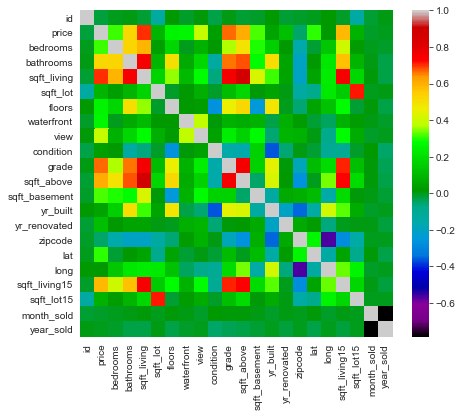

In [34]:
# plot heatmap
plt.figure(figsize=(7,6))
sns.heatmap(df.corr(), cmap= 'nipy_spectral')

Looking at the heatmap above, we can easily see the orange and red squares are highly correlated.

When looking at the price column specifically, we find that "sqft_living" has the highest correlation so far. 
The column "sqft_living" is also highly correlated with "sqft_above". Having both of these is redundant. Let's get rid of one and see what that does.

In [35]:
df1 = df.drop(columns= ['sqft_above'])

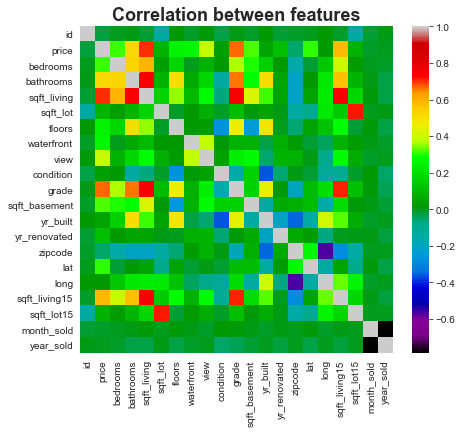

In [36]:
plt.figure(figsize=(7,6))
sns.heatmap(df1.corr(), cmap= 'nipy_spectral')
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Looks okay. Now let's sort them between categorical and continuous.

Let's look at the distributions on the continuous columns

In [37]:
continuous = []
categorical = []

for col in df.columns:
    if (df[col].nunique() < 15):
        categorical.append(col)
    else:
        continuous.append(col)

In [38]:
continuous

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [39]:
categorical

['bedrooms',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'month_sold',
 'year_sold']

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>],
       [<AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

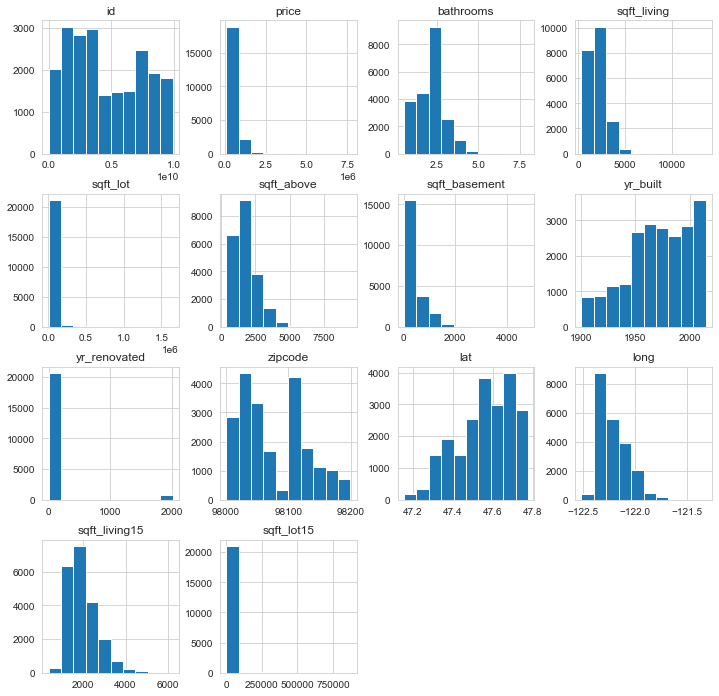

In [40]:
df_continuous = df.loc[:, continuous]
df_continuous.hist(figsize= (12, 12))

Difficult to see "sqft_lot" and "sqft_lot15" and "price" due to the scale of the graphs. But none of these look particularly "normal" in their distributions.

In [41]:
# g = sns.pairplot(df[['price', 'sqft_living', 'yr_built','zipcode']], 
#                  hue= 'price', palette= 'deep', height= 5)

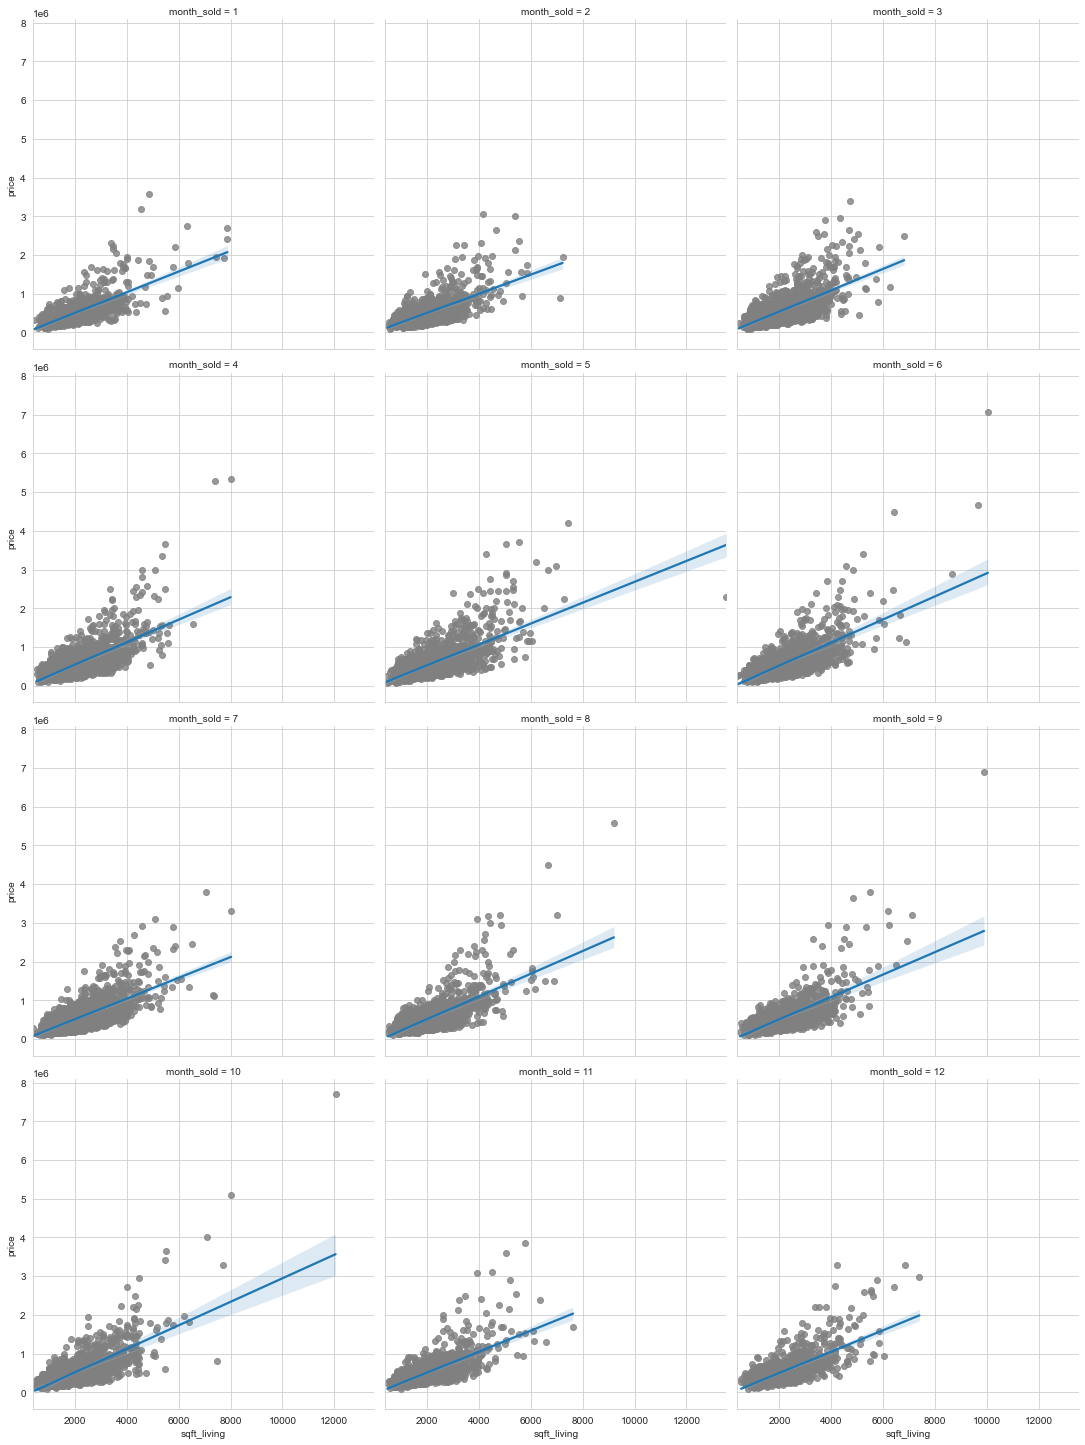

In [42]:
g1 = sns.lmplot(x= 'sqft_living', y= 'price', data= df, col= 'month_sold', 
               col_wrap= 3, scatter_kws = {'color': 'gray'})

I can see there are some large houses and some expensive houses. Definitely going to have to remove some outliers.

## Baseline model

In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [44]:
df1 = df.copy()
outcome = 'price'
x_cols = df1.drop(['price', 'id', 'sqft_basement', 'sqft_living15', 
                 'sqft_lot15'], axis= 1).columns
x_cols

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'month_sold', 'year_sold'],
      dtype='object')

In [45]:
predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= df1).fit()

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2949.
Date:                Wed, 06 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:57:24   Log-Likelihood:            -2.9195e+05
No. Observations:               21419   AIC:                         5.839e+05
Df Residuals:                   21401   BIC:                         5.841e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -6.459e+07   9.97e+06     -6.477      0.000   -8.41e+07    -4.5e+07
bedrooms     -3.922e+04   1989.378    -19.713      0.000   -4.31e+04   -3.53e+04
bathrooms     4.325e+04   3277.565     13.196      0.000    3.68e+04    4.97e+04
sqft_living    156.6232      4.335     36.133      0.000     148.127     165.119
sqft_lot        -0.0644      0.035     -1.853      0.064      -0.133       0.004
floors        5528.6656   3582.303      1.543      0.123   -1492.917    1.26e+04
waterfront    6.129e+05   1.81e+04     33.815      0.000    5.77e+05    6.48e+05
view          5.449e+04   2101.273     25.932      0.000    5.04e+04    5.86e+04
condition      2.72e+04   2362.820     11.512      0.000    2.26e+04    3.18e+04
grade         1.007e+05   2079.053     48.424      0.000    9.66e+04    1.05e+05
sqft_above      33.9803      4.324      7.858      0.000      25.504      42.456
yr_built     -2675.6176     72.161    -37.078      0.000   -2817.059   -2534.176
yr_renovated    23.0348      3.985      5.780      0.000      15.224      30.846
zipcode       -606.6377     32.988    -18.389      0.000    -671.297    -541.978
lat           6.078e+05   1.08e+04     56.501      0.000    5.87e+05    6.29e+05
long         -2.112e+05    1.3e+04    -16.252      0.000   -2.37e+05   -1.86e+05
month_sold    1223.7259    709.491      1.725      0.085    -166.929    2614.381
year_sold     3.671e+04   4731.664      7.758      0.000    2.74e+04     4.6e+04
==============================================================================
Omnibus:                    17941.102   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1725870.971
Skew:                           3.493   Prob(JB):                         0.00
Kurtosis:                      46.417   Cond. No.                     7.22e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Columns "floors" and "sqft_lot" have higher p-values than we'd like (< 0.05).

Baseline $R^{2}$ = 0.701

We can do some more cleaning and manipulating to get it better than that.

### Improving baseline model

It's time to limit features that are out of reach for a first time home buyer.
Those features include things like:
* price
* square footage
* grades
* conditions
* bedrooms

<AxesSubplot:xlabel='price'>

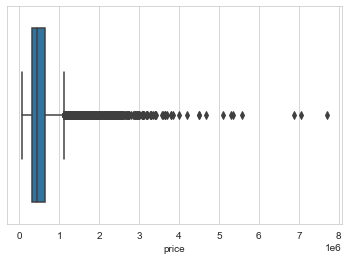

In [47]:
#  Check out price - remove outliers and houses that are out of budget
#  Assume for first time home buyer - budget is not more than $500,000
sns.boxplot(x= df['price'])

In [48]:
# remove houses that sold for > $500,000
df = df[df['price'] <= 500000]

<AxesSubplot:xlabel='bedrooms'>

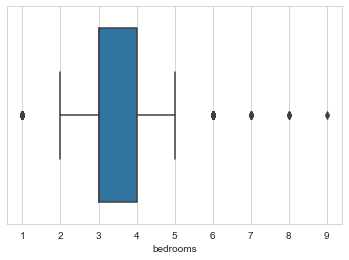

In [49]:
sns.boxplot(x= df['bedrooms'])

In [50]:
# remove houses with more than 5 bedrooms
df = df[df['bedrooms'] <= 5]

<AxesSubplot:xlabel='grade', ylabel='price'>

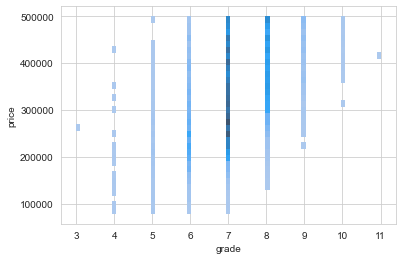

In [51]:
#Looking at grades of the houses
sns.histplot(x= 'grade', y= 'price', data= df)

In [52]:
print (len(df))
len(df[df['grade'] == 4])

12301


27

In [53]:
# going to take out grades, 4, 10, and 11
df = df.loc[(df['grade'] >= 5) & (df['grade'] <= 9)]

<AxesSubplot:xlabel='condition', ylabel='price'>

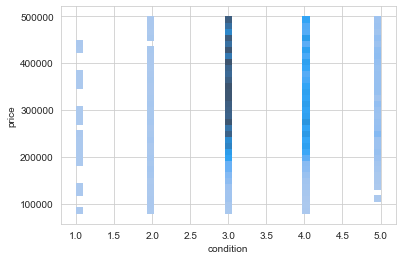

In [54]:
sns.histplot(x= 'condition', y= 'price', data= df)

In [55]:
# percent of houses with a condition of "2" 
len(df[df['condition'] == 2]) / len(df)

0.011191896086921003

In [56]:
# The first time home buyer deserves something that doesn't need a lot of work
# Get rid of houses with a condition rating of 2 or less.
df = df[df['condition'] >= 3]

<AxesSubplot:xlabel='yr_built'>

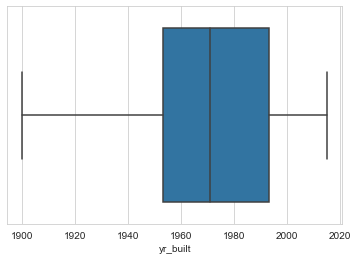

In [57]:
sns.boxplot(x= df['yr_built'])

In [58]:
# We want to keep the newer houses, but get rid of older houses that may need
# repairs, renovations, and upkeep

# First, let's look at houses that were built from 1900 - 1940 that
# had renovations since the year 2000
len(df.loc[(df['yr_built'] <= 1940) & (df['yr_renovated'] >= 2000)])

42

In [59]:
# Not too many older homes that were renovated
# Let's simplify it and remove all homes older than 1940
df = df[df['yr_built'] >= 1940]

<AxesSubplot:xlabel='yr_built'>

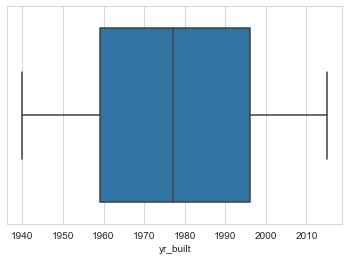

In [60]:
sns.boxplot(x= df['yr_built'])

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10726 entries, 0 to 21419
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10726 non-null  int64  
 1   price          10726 non-null  float64
 2   bedrooms       10726 non-null  int64  
 3   bathrooms      10726 non-null  float64
 4   sqft_living    10726 non-null  int64  
 5   sqft_lot       10726 non-null  int64  
 6   floors         10726 non-null  float64
 7   waterfront     10726 non-null  float64
 8   view           10726 non-null  float64
 9   condition      10726 non-null  int64  
 10  grade          10726 non-null  int64  
 11  sqft_above     10726 non-null  int64  
 12  sqft_basement  10726 non-null  float64
 13  yr_built       10726 non-null  int64  
 14  yr_renovated   10726 non-null  float64
 15  zipcode        10726 non-null  int64  
 16  lat            10726 non-null  float64
 17  long           10726 non-null  float64
 18  sqft_l

In [ ]:
# get rid of columns you won't use
# https://www.youtube.com/watch?v=8_Le51miL-8
# https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [62]:
# df2 = df1[['price', 'waterfront', 'yr_built', 'sqft_living15', 'zipcode']]

In [63]:
# pd.plotting.scatter_matrix(df2, figsize= [11,11]);

In [64]:
# df['zipcode'].hist()
# plt.show()

In [65]:
# df.groupby('lat')['sqft_living'].mean().nlargest(5)
# df.groupby('lat')['sqft_living'].mean().min()
# df.groupby('long')['sqft_living'].mean().max()
# df.loc[(df['sqft_living'] <= 1200) & (df['sqft_living15'] > 2000)]
# df.loc[(df['sqft_living'] >= 3000)]
# df.groupby('long')['sqft_living'].mean().nlargest(5)

# for reference - delete when finished
# df_id_dups.groupby('date')['id'].count()
# df_id_dups= df_id_dups.groupby(['id']).unique().count()

In [66]:
# create boxplot with all columns
# sns.boxplot(data=df, orient= 'h')

# # drop price, sqft_lot, zipcode, and sqft_lot15 to see rest of columns better
# boxplot_df.drop(['price', 'sqft_lot', 'sqft_lot15', 'zipcode'], axis= 1, inplace= True)

# # plot only one column in boxplot
# print (df['price'].nlargest(5))
# sns.boxplot(x= df['price'])

In [67]:
#  How to remove everything after 2 standard deviations - can also use lambda
# df = df[(np.abs(stats.zscore(df)) < 2).all(axis=1)]
# df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 1).all(axis=1)]

#can filter by column too - here "B" is name of column
# df[((df.B - df.B.mean()) / df.B.std()).abs() < 2]